<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using LIME for coffee dataset classifier
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the [Coffee dataset](https://www.timeseriesclassification.com/description.php?Dataset=Coffee).

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

### Import libraries

In [2]:
import dianna
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from dianna.utils.downloader import download

#### 1 - Loading the data
Load coffee dataset.

In [3]:
# Load coffee dataset
coffee_train = pd.read_csv(download('coffee_train.csv', 'data'),
                            sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv(download('coffee_test.csv', 'data'),
                           sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

#### 2 - Define a KNN model to classify two types of coffee
Here we train a simple k-nearest neighbors (KNN) model for classification task.

In [4]:
# Define and train model
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
print('Accuracy KNN for coffee dataset: %f' % (acc(coffee_test_y, knn.predict(coffee_test_x))))

Accuracy KNN for coffee dataset: 0.964286


An instance is selected for explanation.

In [5]:
# Select instance for explanation
idx = 5 # explained instance
series = coffee_test_x.iloc[idx, :]
num_features = len(series) # how many feature contained in explanation
num_slices = len(series) # split time series

class_names = ['Arabica', 'Robusta']
labels = np.argsort(class_names)
series.shape

(286,)

Note that the LIME timeseries explainer in DIANNA can only receive input in the order of [timeseries, channels]. Given the way that the model was trained, we need to create an model runner for the explainer.

In [6]:
# the explainer must receive input in the order of [timeseries, channels]
data_instance = np.expand_dims(series, axis=1)
def run_model(data):
    data = data[:,:,0]
    return knn.predict_proba(data)

#### 3 - Applying LIME with DIANNA for timeseries

In this section we apply LIME to this KNN model to calculate the relevance score and visualize the results.

In [7]:
exp = dianna.explain_timeseries(run_model, input_timeseries=data_instance, method='lime',
                                labels=[0,1], class_names=class_names, num_features=num_features,
                                num_samples=500, num_slices=num_slices, distance_method='cosine')

Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1386.36it/s]


Now we can visualize results using the built-in visualizer in `LIME` explainer. The elements contributing positively towards the classification decision are indicated in 'red' and those contributing negatively - in 'blue'.

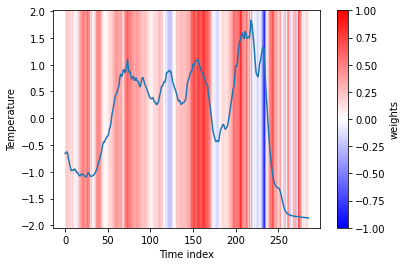

In [8]:
from dianna import visualization
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

heatmap_channel = normalize(exp[0])
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
fig, _ = visualization.plot_timeseries(range(len(heatmap_channel)), data_instance,
                              segments, x_label="Time index", y_label="Temperature")

#### 4- Experiment with ONNX
DIANNA supports ONNX models. Here we demonstrate the use of LIME explainer for timeseries with a pre-trained ONNX model, which is a random forest classifier for the same [Coffee dataset](https://www.timeseriesclassification.com/description.php?Dataset=Coffee). <br>

The model is trained by this [notebook](https://github.com/dianna-ai/dianna-exploration/blob/main/example_data/model_generation/coffee/generate_model.ipynb): <br>

In [9]:
from dianna.utils.onnx_runner import SimpleModelRunner

model_path = download('coffee.onnx', 'model')
loaded_model = SimpleModelRunner(model_path)
predictions = loaded_model(data_instance.T.astype(np.float32))

A runner function is required since the model works with input in the order of [channels, timeseries], while LIME in DIANNA should receive input in the opposite order. 

In [10]:
import onnxruntime as ort

def run_model(data):
    # model must receive input in the order of [channels, timeseries]
    # get ONNX predictions
    predictions = []
    for i in range(data.shape[0]):
        input_data = data[i].T
        sess = ort.InferenceSession(model_path)
        input_name = sess.get_inputs()[0].name
        output_name = sess.get_outputs()[0].name

        onnx_input = {input_name: input_data.astype(np.float32)}
        pred_onnx = sess.run([output_name], onnx_input)[0]
        predictions.append(pred_onnx)
    
    return np.asarray(predictions)

Now we can call the explainer and visualize the results.

In [11]:
exp = dianna.explain_timeseries(run_model, input_timeseries=data_instance, method='lime',
                                labels=[0], class_names=class_names, num_features=num_features,
                                num_samples=500, num_slices=num_slices, batch_size=1, distance_method='cosine')

Explaining: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 345.87it/s]


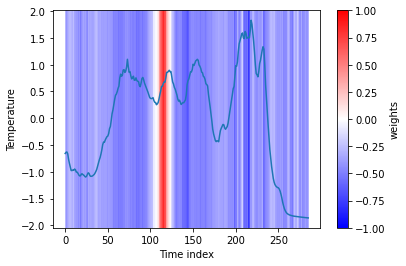

In [12]:
heatmap_channel = normalize(exp[0])
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
fig, _ = visualization.plot_timeseries(range(len(heatmap_channel)), data_instance,
                              segments, x_label="Time index", y_label="Temperature")

#### 5 - Conclusions
The importance of each segmententation of timeseries to the classification result is shown in the image. This is achieved by applying LIME approach to timeseries.

Both examples ...(To be completed.)